In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from langdetect import detect
import re
import nltk; nltk.download('popular')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer
import spacy
from spacy import displacy
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from IPython.core.display import display, HTML
from sklearn.decomposition import NMF
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import jaccard_score
from sklearn.ensemble import RandomForestClassifier
import joblib
from wordcloud import WordCloud
import sklearn.metrics as metrics
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
import pyLDAvis.gensim_models 
from sklearn.manifold import TSNE
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\Maroua.Missaoui\AppData\Roaming\nltk_dat
[nltk_data]    |     a...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\Maroua.Missaoui\AppData\Roaming\nltk_dat
[nltk_data]    |     a...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\Maroua.Missaoui\AppData\Roaming\nltk_dat
[nltk_data]    |     a...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\Maroua.Missaoui\AppData\Roaming\nltk_dat
[nltk_data]    |     a...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\Maroua.Missaoui\AppData\Roaming\nlt

In [223]:
#read data 
df_init=pd.read_csv('data/QueryResults.csv',encoding='latin-1')
#df explore
print('df.shape : ' ,df_init.shape)
print('df.head() : ', df_init.head())


df.shape :  (27049, 8)
df.head() :                                                 Title  \
0  How to generate a core dump in Linux on a segm...   
1  Dealing with PHP server and MySQL server in di...   
2  Can I use autolayout to provide different cons...   
3  Loading System.ServiceModel configuration sect...   
4  Recommended SQL database design for tags or ta...   

                                                Body  \
0  <p>I have a process in Linux that's getting a ...   
1  <p>For those of us who use standard shared hos...   
2  <p>Is it possible to change the constraints wh...   
3  <p>Using C# .NET 3.5 and WCF, I'm trying to wr...   
4  <p>I've heard of a few ways to implement taggi...   

                                                Tags        Id  Score  \
0                <linux><bash><unix><coredump><tcsh>     17965    237   
1             <php><mysql><datetime><date><timezone>     18449     12   
2  <ios><cocoa-touch><uiview><uiviewcontroller><a...  17772922     48  

In [224]:
print(df_init.info(),'\n')
print('null values ? ', df_init.isnull().values.any(),'\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27049 entries, 0 to 27048
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          27049 non-null  object
 1   Body           27049 non-null  object
 2   Tags           27049 non-null  object
 3   Id             27049 non-null  int64 
 4   Score          27049 non-null  int64 
 5   ViewCount      27049 non-null  int64 
 6   FavoriteCount  27049 non-null  int64 
 7   AnswerCount    27049 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 1.7+ MB
None 

null values ?  False 



#1.1 Analyse de la longueur des questions et filtre sur les questions ayant des tags dans le top 30 des tags les plus utilisés sur Stackoverflow et dont la langue est anglais
#Body length

In [225]:
body_length=df_init['Body'].str.len()
print('longueur de la question :' ,body_length )

longueur de la question : 0          128
1          389
2          403
3          930
4          454
         ...  
27044      529
27045      301
27046    10181
27047     9616
27048      627
Name: Body, Length: 27049, dtype: int64


<Figure size 1440x864 with 0 Axes>

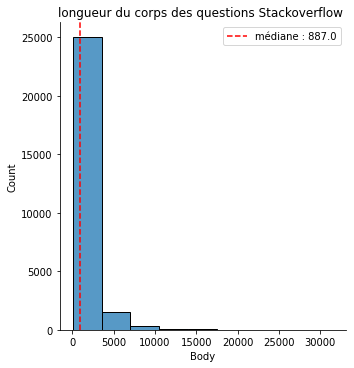

In [226]:
fig = plt.figure(figsize=(20, 12))
ax = sns.displot(x=body_length,binwidth=3500)

plt.axvline(df_init.Body.str.len().median() - df_init.Body.str.len().min(),
            color="r", linestyle='--',
            label="médiane : "+str(df_init.Body.str.len().median()))

plt.title("longueur du corps des questions Stackoverflow "
          )
plt.legend()
plt.show()

#==> la majeure partie des questions ont une longueur <5000

#je garde  les questions ayant un body <5000 caractères

In [227]:
df_init = df_init[df_init.Body.str.len() < 5000]
print('shape df ', df_init.shape)

shape df  (26054, 8)


#analyse tags

In [228]:
print('df[tags]',df_init['Tags'].head())

df[tags] 0                  <linux><bash><unix><coredump><tcsh>
1               <php><mysql><datetime><date><timezone>
2    <ios><cocoa-touch><uiview><uiviewcontroller><a...
3           <c#><.net><xml><wcf><configurationmanager>
4    <sql><database-design><tags><data-modeling><ta...
Name: Tags, dtype: object


In [229]:
# Replacer < > avec ,
df_init['Tags'] = df_init['Tags'].str.translate(str.maketrans({'<': '', '>': ','}))
df_init['Tags'] =df_init['Tags'].str[:-1]
print('remplacement de < > par , dans tags ',df_init['Tags'].head())

remplacement de < > par , dans tags  0                        linux,bash,unix,coredump,tcsh
1                     php,mysql,datetime,date,timezone
2    ios,cocoa-touch,uiview,uiviewcontroller,autola...
3                 c#,.net,xml,wcf,configurationmanager
4       sql,database-design,tags,data-modeling,tagging
Name: Tags, dtype: object


In [230]:
def count_split_tags(df, column, separator):

    list_words = []
    for word in df[column].str.split(separator):
        list_words.extend(word)
    df_list_words = pd.DataFrame(list_words, columns=["Tag"])
    df_list_words = df_list_words.groupby("Tag")\
        .agg(tag_count=pd.NamedAgg(column="Tag", aggfunc="count"))
    df_list_words.sort_values("tag_count", ascending=False, inplace=True)
    return df_list_words

In [231]:
tags_list = count_split_tags(df=df_init, column='Tags', separator=',')
print("Le jeu de données compte {} tags.".format(tags_list.shape[0]))

Le jeu de données compte 12150 tags.


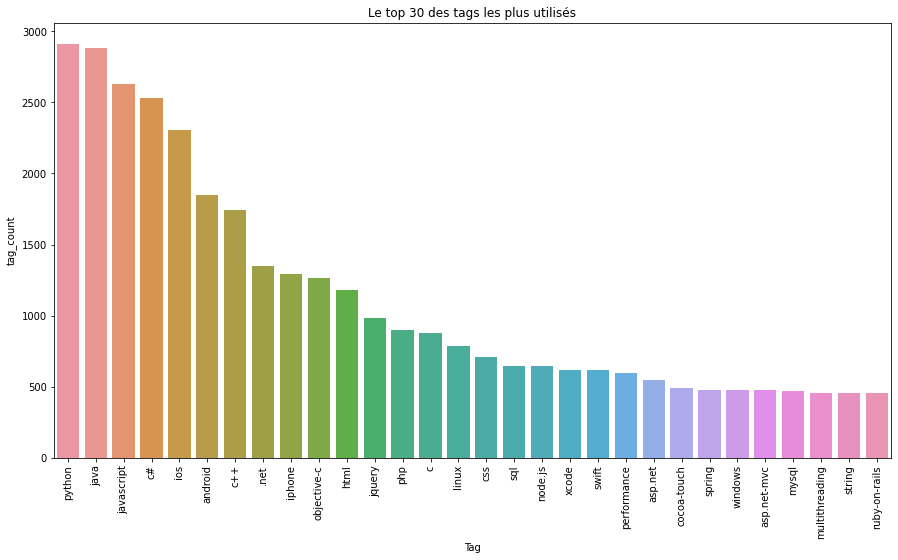

In [232]:
# Plot the results of splits
fig = plt.figure(figsize=(15, 8))
sns.barplot(data=tags_list.iloc[0:30, :],
            x=tags_list.iloc[0:30, :].index,
            y="tag_count")
plt.xticks(rotation=90)
plt.title("Le top 30 des tags les plus utilisés")
plt.show()

In [233]:
# Create a list of Tags and count the number
df_init['Tags_list'] = df_init['Tags'].str.split(',')
df_init['Tags_count'] = df_init['Tags_list'].apply(lambda x: len(x))

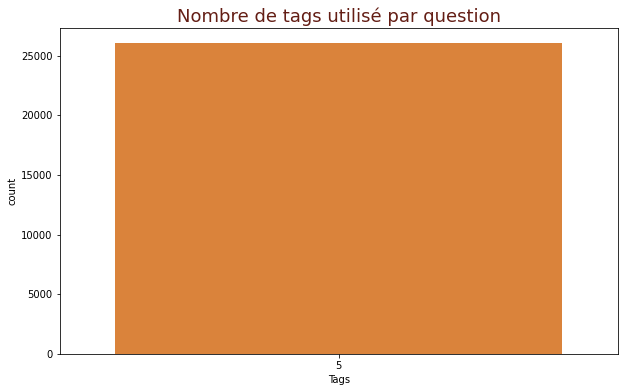

In [234]:
# Plot the result
fig = plt.figure(figsize=(10, 6))
ax = sns.countplot(x=df_init.Tags_count, color="#f48020")
ax.set_xlabel("Tags")
plt.title("Nombre de tags utilisé par question",
          fontsize=18, color="#641E15")
plt.show()

Filter les tags pour garder les plus utilisés 

In [235]:
def filter_tag(x, top_list):

    temp_list = []
    for item in x:
        if (item in top_list):
            #x.remove(item)
            temp_list.append(item)
    return temp_list

In [236]:
top_tags = list(tags_list.iloc[0:30].index)
df_init['Tags_list'] = df_init['Tags_list']\
                    .apply(lambda x: filter_tag(x, top_tags))
df_init['number_of_tags'] = df_init['Tags_list'].apply(lambda x : len(x))
df_init = df_init[df_init.number_of_tags > 0]
print("shape du jeu de données : {} questions.".format(df_init.shape[0]))

shape du jeu de données : 21583 questions.


#analyse de langue

In [237]:
def detect_lang(x):
    try:
        return detect(x)
    except:
        pass

df_init['short_body'] = df_init['Body'].apply(lambda x: x[0:100])
df_init['lang'] =df_init.short_body.apply(detect_lang)

print('langue détectée dans les questions ',pd.DataFrame(df_init.lang.value_counts()))
#l'anglais est majoritaire dans le jeu de données donc on supprime les autres langues pour simplifier l'analyse
df_init = df_init[df_init['lang']=='en']
print("shape du jeu de données après filtre sur la langue==en ", df_init.shape)

langue détectée dans les questions       lang
en  21293
ca     60
fr     59
pt     41
cy     31
it     18
ro     17
es     16
nl     13
da     12
no      9
af      5
sk      2
tl      2
de      2
sv      1
et      1
hr      1
shape du jeu de données après filtre sur la langue==en  (21293, 13)


#1.2 text preprocessing

In [238]:
#suppression des balises HTML qui sont dans le Body des questions
def remove_html(x):
    beautifulsoup = BeautifulSoup(x,"lxml")
    to_remove = beautifulsoup.findAll("code")
    for code in to_remove:
        code.replace_with(" ")
    return str(beautifulsoup)

df_init['Body'] = df_init['Body'].apply(remove_html)
# Delete all html tags
df_init['Body'] = [BeautifulSoup(text,"lxml").get_text() for text in df_init['Body']]
print("suppression balise html du body ", df_init['Body'].head(),'\n')

suppression balise html du body  0    I have a process in Linux that's getting a seg...
1    For those of us who use standard shared hostin...
2    Is it possible to change the constraints when ...
3    Using C# .NET 3.5 and WCF, I'm trying to write...
4    I've heard of a few ways to implement tagging;...
Name: Body, dtype: object 



In [239]:
def text_cleaner(x, nlp):
    # POS not in "NOUN", "PROPN"
    #x = remove_pos(nlp, x, pos_list)
    # Case lower
    x = x.lower()
    # Remove unicode characters
    x = x.encode("ascii", "ignore").decode()
    # Remove English contractions
    x = re.sub("\'\w+", '', x)
    # Remove ponctuation but not # (for C# for example)
    x = re.sub('[^\\w\\s#]', '', x)
    # Remove links
    x = re.sub(r'http*\S+', '', x)
    # Remove numbers
    x = re.sub(r'\w*\d+\w*', '', x)
    # Remove extra spaces
    x = re.sub('\s+', ' ', x)
    
    # Return cleaned text
    return x

In [240]:
 #clean body
nlp = spacy.load("en_core_web_sm")
pos_list=["NOUN","PROPN"]
def remove_pos(d):
    doc1= nlp(d)
    list_text_row = []
    for token in doc1:
        if(token.pos_ in pos_list) :
            list_text_row.append(token.text)
    join_text_row = " ".join(list_text_row)
    join_text_row = join_text_row.lower().replace("c #", "c#")
    return join_text_row

tqdm.pandas()
df_init['Body_cleaned'] = df_init["Body"].progress_apply(lambda x : text_cleaner(x, nlp))

print("spacy clean ", df_init['Body_cleaned'].head(20),'\n')
df_init['Body_cleaned'] = df_init["Body"].progress_apply(lambda x : remove_pos(x))
print("spacy keep noun ", df_init['Body_cleaned'].head(20),'\n')


100%|██████████| 21293/21293 [00:02<00:00, 9348.61it/s]


spacy clean  0     i have a process in linux that getting a segme...
1     for those of us who use standard shared hostin...
2     is it possible to change the constraints when ...
3     using c# net and wcf i trying to write out som...
4     i heard of a few ways to implement tagging usi...
5     following on from my previous question i have ...
6     i working on a projects which involves a lot o...
7     how do i go about specifying and using an enum...
8     we got a page with a ton of jquery approximate...
9     in the c and c programming languages what is t...
10    could somebody please do a rundown of how to p...
11    is there a simple way in net to quickly get th...
12    i currently writing an aspnet app from the ui ...
13    prior to c# generics everyone would code colle...
14    i have a img encoded that you can find here ho...
15    when performance is essential to an applicatio...
17    i am on centos bit and am trying to cause a bu...
18    which files should i include 

100%|██████████| 21293/21293 [05:49<00:00, 60.95it/s]

spacy keep noun  0            process linux segmentation fault core dump
1     packages godaddy network solutions datetime co...
2     constraints device example images portrait lan...
3     c# .net wcf wcf configuration client applicati...
4     ways tagging mapping table tagid itemid sense ...
5     question object model xml problem quelle surpr...
6     projects lot database % inserts % reads ratio ...
7                                     enum django model
8     page ton jquery lines b c maintenance nightmar...
9     c c++ programming languages difference angle b...
10    rundown config file .net c# kind check applica...
11    way .net protocol host port example url url ho...
12    app ui mvp architecture winforms separation co...
13    c# generics collections business objects colle...
14                              base64 img height width
15    performance application consideration array st...
17    centos bit buffer overflow program gdb output ...
18                             

In [241]:
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

In [242]:
df_init['Body_cleaned'] = df_init.Body_cleaned.apply(lemmatize_text)
print('\n')
print("lemma text ", df_init['Body_cleaned'])



lemma text  0        [process, linux, segmentation, fault, core, dump]
1        [package, godaddy, network, solution, datetime...
2        [constraint, device, example, image, portrait,...
3        [c#, .net, wcf, wcf, configuration, client, ap...
4        [way, tagging, mapping, table, tagid, itemid, ...
                               ...                        
27041    [sha-1, flutter, app, android, studio, google,...
27043    [database, survey, university, professor, pyth...
27044    [android, pie, request, encryption, default, s...
27045    [s, react, router, /cards, list, card, game, /...
27048    [document, warning, console, deprecationwarnin...
Name: Body_cleaned, Length: 21293, dtype: object


In [243]:
# Create a list of all tokens for Body
full_corpus = []
for i in df_init['Body_cleaned']:
    full_corpus.extend(i)

In [244]:
# Calculate distribition of words in Body token list
body_dist = nltk.FreqDist(full_corpus)
body_dist = pd.DataFrame(body_dist.most_common(2000),
                         columns=['Word', 'Frequency'])

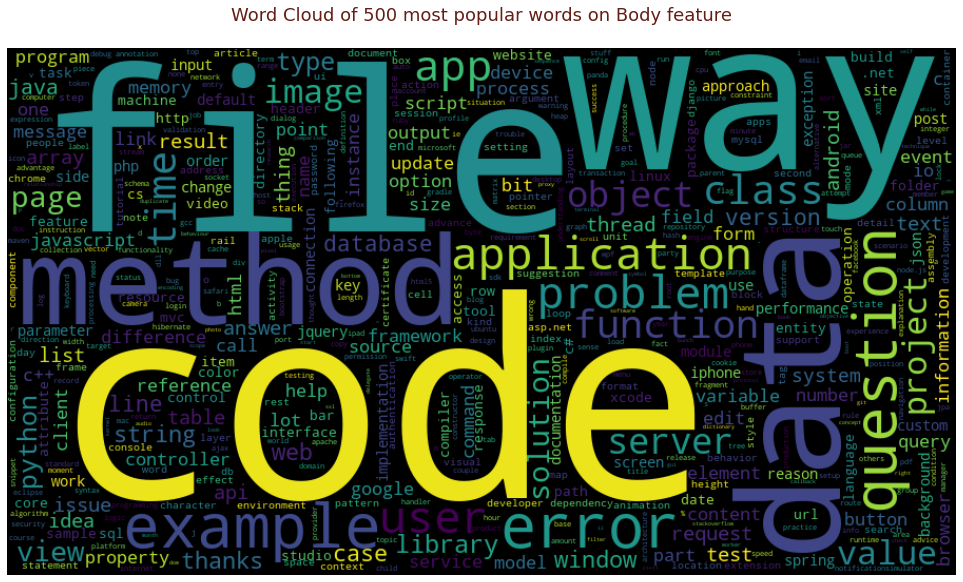

In [245]:
# Plot word cloud with tags_list (frequencies)
fig = plt.figure(1, figsize=(17, 12))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(body_dist.set_index('Word').to_dict()['Frequency'])

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Word Cloud of 500 most popular words on Body feature\n",
          fontsize=18, color="#641E16")
plt.show()

Nettoyage du titre de la question

In [246]:
def text_cleaner(x, nlp, pos_list, lang="english"):
    x = remove_pos(x)
    # Case normalization
    x = x.lower()
    # Remove unicode characters
    x = x.encode("ascii", "ignore").decode()
    # Remove English contractions
    x = re.sub("\'\w+", '', x)
    # Remove ponctuation but not # (for C# for example)
    x = re.sub('[^\\w\\s#]', '', x)
    # Remove links
    x = re.sub(r'http*\S+', '', x)
    # Remove numbers
    x = re.sub(r'\w*\d+\w*', '', x)
    # Remove extra spaces
    x = re.sub('\s+', ' ', x)
        
    # Tokenization
    x = nltk.tokenize.word_tokenize(x)
    # List of stop words in select language from NLTK
    stop_words = stopwords.words(lang)
    # Remove stop words
    x = [word for word in x if word not in stop_words 
         and len(word)>2]
    # Lemmatizer
    wn = nltk.WordNetLemmatizer()
    x = [wn.lemmatize(word) for word in x]
    
    # Return cleaned text
    return x


In [247]:
pos_list = ["NOUN","PROPN"]
tqdm.pandas()
df_init['Title_cleaned'] = df_init.Title.progress_apply(lambda x: text_cleaner(x,nlp,pos_list,"english"))

print("nettoyage titre ",df_init['Title_cleaned'].head(20))

100%|██████████| 21293/21293 [01:46<00:00, 200.70it/s]

nettoyage titre  0              [core, dump, linux, segmentation, fault]
1              [php, server, mysql, server, time, zone]
2     [autolayout, constraint, landscape, portrait, ...
3     [loading, system, servicemodel, configuration,...
4                          [sql, database, design, tag]
5                 [xml, serialization, inherited, type]
6                                      [myisam, innodb]
7                          [mysql, enum, django, model]
8                           [jquery, ajax, updatepanel]
9                                [difference, filename]
10                                  [config, file, net]
11                          [net, protocol, host, port]
12    [communicate, service, layer, message, error, ...
13     [list, businessobject, businessobjectcollection]
14                         [image, width, height, code]
15                          [performance, array, array]
17                                  [buffer, work, gdb]
18                          [gi

reconstituer le dataframe nettoyé

In [248]:
df_init = df_init[['Title_cleaned',
             'Body_cleaned',
             'Score',
             'Tags_list']]

df_init = df_init.rename(columns={'Title_cleaned': 'Title',
                            'Body_cleaned': 'Body',
                            'Tags_list': 'Tags'})

print ("dataset nettoye ", df_init.head(),"\n")

dataset nettoye                                                 Title  \
0           [core, dump, linux, segmentation, fault]   
1           [php, server, mysql, server, time, zone]   
2  [autolayout, constraint, landscape, portrait, ...   
3  [loading, system, servicemodel, configuration,...   
4                       [sql, database, design, tag]   

                                                Body  Score  \
0  [process, linux, segmentation, fault, core, dump]    237   
1  [package, godaddy, network, solution, datetime...     12   
2  [constraint, device, example, image, portrait,...     48   
3  [c#, .net, wcf, wcf, configuration, client, ap...     64   
4  [way, tagging, mapping, table, tagid, itemid, ...    324   

                 Tags  
0             [linux]  
1        [php, mysql]  
2  [ios, cocoa-touch]  
3          [c#, .net]  
4               [sql]   



In [249]:
df_init.to_csv('data/clean_data.csv',sep=';')

Transformation en matrix de TF-IDF features

In [250]:

df_init["Text"] = df_init["Title"] + df_init["Body"]
print("df_init[Text].head(3)", df_init["Text"].head(3))
X = df_init["Text"]
y = df_init["Tags"]

print( "X shape ", X.shape)
print("y shape ",y.shape)


vectorizer = TfidfVectorizer(analyzer="word",
                             max_df=0.5,
                             min_df=0.001,
                             ngram_range=[1,3],
                             tokenizer=None,
                             preprocessor=' '.join,
                             stop_words='english',
                             lowercase=False)

vectorizer.fit(X)
X_tf_idf = vectorizer.transform(X)

print('X_tf_idf.shape',X_tf_idf.shape,'\n')
print('y.shape',y.shape)

df_init[Text].head(3) 0    [core, dump, linux, segmentation, fault, proce...
1    [php, server, mysql, server, time, zone, packa...
2    [autolayout, constraint, landscape, portrait, ...
Name: Text, dtype: object
X shape  (21293,)
y shape  (21293,)
X_tf_idf.shape (21293, 3524) 

y.shape (21293,)


In [251]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(y)
y_binarized = multilabel_binarizer.transform(y)

print("Shape of y: {}".format(y_binarized.shape))

Shape of y: (21293, 30)


Gensim :Creating Bigram and Trigram Models

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [252]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [253]:
#min_count= minimum number of times it needs to occur to be considered a bigram 
bigram_phrase = gensim.models.Phrases(X, min_count=2, threshold=50)
trigram_phrase = gensim.models.Phrases(bigram_phrase[X], threshold=100) 

In [254]:
bigram_mod = gensim.models.phrases.Phraser(bigram_phrase)
trigram_mod = gensim.models.phrases.Phraser(trigram_phrase)

In [255]:
# Form Bigrams
data_words_bigrams = make_trigrams(X)
print (data_words_bigrams[0][0:50])

['core_dump', 'linux', 'segmentation_fault', 'process', 'linux', 'segmentation_fault', 'core_dump']


Create the Dictionary and Corpus needed for Topic Modeling

In [256]:
from gensim.models import TfidfModel
id2word=corpora.Dictionary(data_words_bigrams)
print(id2word)

Dictionary<36805 unique tokens: ['core_dump', 'linux', 'process', 'segmentation_fault', 'advice']...>


In [257]:
corpus=[id2word.doc2bow(text) for text in data_words_bigrams]

In [258]:
tfidf=TfidfModel(corpus,id2word=id2word)

In [259]:
corpus[0][0:20]

[(0, 2), (1, 2), (2, 1), (3, 2)]

if a word occurs below a certain frequency here the low_value variable , we assume that it is ubiquitous

In [260]:
low_value = 0.03 
words =[]
words_missing_in_tfidf = [ ] 
for i in range(0, len(corpus)): 
  bow = corpus[i] 
  low_value_words = [] 
  tfidf_ids =[id for id, value in tfidf[bow]] 
  bow_ids = [id for id, value in bow]
  low_value_words =[id for id, value in tfidf[bow] if value < low_value] 
  drops =low_value_words+words_missing_in_tfidf 
  for item in drops : 
    words.append(id2word[item] ) 
  words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] 

  new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
  corpus[i]=new_bow


Building the Topic Model LDA with gensim

In [261]:
lda_model =  gensim.models.LdaMulticore(corpus, 
                                   num_topics =9, 
                                   id2word = id2word,                                    
                                   workers = 4,
                                   passes=10)

In [262]:
#View the topics in LDA model
#For each topic, we will explore the words occuring in that topic and its relative weight
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.036*"view" + 0.019*"button" + 0.018*"image" + 0.015*"text" + 0.014*"page" + 0.012*"code" + 0.012*"controller" + 0.011*"screen" + 0.010*"color" + 0.010*"element"


Topic: 1 
Words: 0.033*"server" + 0.020*"application" + 0.019*"request" + 0.018*"error" + 0.018*"web" + 0.015*"service" + 0.015*"user" + 0.014*"client" + 0.013*"api" + 0.011*"code"


Topic: 2 
Words: 0.033*"value" + 0.029*"string" + 0.029*"type" + 0.028*"column" + 0.018*"python" + 0.017*"time" + 0.015*"date" + 0.013*"way" + 0.012*"row" + 0.010*"data"


Topic: 3 
Words: 0.043*"function" + 0.037*"code" + 0.023*"class" + 0.014*"javascript" + 0.013*"array" + 0.012*"way" + 0.011*"question" + 0.011*"example" + 0.011*"python" + 0.010*"object"


Topic: 4 
Words: 0.050*"data" + 0.026*"database" + 0.021*"object" + 0.020*"table" + 0.016*"user" + 0.015*"way" + 0.013*"query" + 0.013*"model" + 0.011*"key" + 0.009*"json"


Topic: 5 
Words: 0.087*"file" + 0.022*"error" + 0.021*"project" + 0.017*"window" + 0.017*"python" + 

In [263]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
lda_viz = gensimvis.prepare(lda_model, corpus, id2word)
lda_viz


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.119195  0.038043       1        1  15.296013
3      0.097509  0.040583       2        1  13.711478
5     -0.103203  0.190807       3        1  13.289821
7      0.146583 -0.002094       4        1  11.840371
0     -0.080283 -0.206741       5        1  11.809525
4      0.056477 -0.067602       6        1  11.681435
8     -0.116224 -0.071549       7        1   7.946577
2      0.214084  0.022599       8        1   7.421584
6     -0.095748  0.055955       9        1   7.003196, topic_info=         Term         Freq        Total Category  logprob  loglift
41       file  8115.000000  8115.000000  Default  30.0000  30.0000
164       app  4577.000000  4577.000000  Default  29.0000  29.0000
40       data  5102.000000  5102.000000  Default  28.0000  28.0000
294  function  4248.000000  4248.000000  Default  27.0000  27.0000
31       view  2891.000000  2891.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
164       app   194.793069  4577.609574   Topic9  -5.4177  -0.4982
180     error   190.497498  4916.601960   Topic9  -5.4400  -0.5919
51        way   190.514711  6082.070935   Topic9  -5.4399  -0.8046
20       code   190.438133  8318.662874   Topic9  -5.4403  -1.1181
391   library   168.308476  2540.086269   Topic9  -5.5639  -0.0554

[721 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
32        1  0.225925            .net
32        2  0.048977            .net
32        3  0.077415            .net
32        4  0.132711            .net
32        6  0.007899            .net
...     ...       ...             ...
290       9  0.223982           xcode
2586      1  0.967858  xmlhttprequest
53        2  0.916441           xpath
53        5  0.076370           xpath
7480      8  0.958197          y_axis

[2444 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 6, 8, 1, 5, 9, 3, 7])

**Compute LDA Coherence Score**


Intra-topic similarity – the similarity of words in the same topic.
Inter-topic similarity – the similarity of words across different topics.

==>maximize intra-topic and minimize inter-topic similarity. Also, by similarity, we imply the cosine similarity between words represented by word2vec embedding.



In [264]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=num_topics,
                                  workers=4)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [265]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=2, limit=30, step=1)

In [266]:
limit=30; start=2; step=1;
x = range(start, limit, step)

In [267]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3995
Num Topics = 3  has Coherence Value of 0.3825
Num Topics = 4  has Coherence Value of 0.382
Num Topics = 5  has Coherence Value of 0.3941
Num Topics = 6  has Coherence Value of 0.3933
Num Topics = 7  has Coherence Value of 0.3919
Num Topics = 8  has Coherence Value of 0.3872
Num Topics = 9  has Coherence Value of 0.3847
Num Topics = 10  has Coherence Value of 0.3832
Num Topics = 11  has Coherence Value of 0.3992
Num Topics = 12  has Coherence Value of 0.3802
Num Topics = 13  has Coherence Value of 0.3941
Num Topics = 14  has Coherence Value of 0.3943
Num Topics = 15  has Coherence Value of 0.3904
Num Topics = 16  has Coherence Value of 0.387
Num Topics = 17  has Coherence Value of 0.3904
Num Topics = 18  has Coherence Value of 0.381
Num Topics = 19  has Coherence Value of 0.3877
Num Topics = 20  has Coherence Value of 0.378
Num Topics = 21  has Coherence Value of 0.3925
Num Topics = 22  has Coherence Value of 0.3977
Num Topics = 23  has Cohe

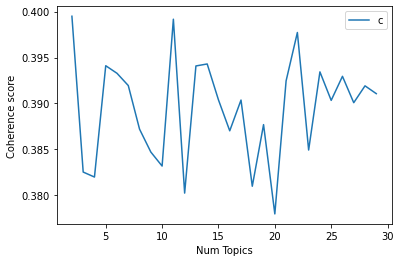

In [268]:
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Trouver le topic le plus dominant dans chaque question

In [269]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words_bigrams):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words_bigrams)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show


In [270]:
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5,0.7228,"file, error, project, window, python, library,...","[core_dump, linux, segmentation_fault, process..."
1,1,1,0.5828,"server, application, request, error, web, serv...","[php, server, mysql, server, time_zone, packag..."
2,2,0,0.9444,"view, button, image, text, page, code, control...","[autolayout_constraint, landscape_portrait, or..."
3,3,1,0.6158,"server, application, request, error, web, serv...","[loading, system, servicemodel, configuration,..."
4,4,4,0.7317,"data, database, object, table, user, way, quer...","[sql, database, design, tag, way, tagging, map..."
5,5,3,0.4199,"function, code, class, javascript, array, way,...","[xml, serialization, inherited, type, question..."
6,6,4,0.7055,"data, database, object, table, user, way, quer...","[myisam, innodb, project, lot, database, %, in..."
7,7,4,0.8888,"data, database, object, table, user, way, quer...","[mysql, enum, django, model, enum, django, model]"
8,8,6,0.5237,"project, application, event, framework, proble...","[jquery, ajax, updatepanel, page, ton, jquery,..."
9,9,3,0.4132,"function, code, class, javascript, array, way,...","[difference, filename, c_c++, programming_lang..."


In [271]:
"""df_dominant_topic['Dominant_Topic'].mask(df_dominant_topic['Dominant_Topic'] ==8 ,'SQL', inplace=True)"""

"df_dominant_topic['Dominant_Topic'].mask(df_dominant_topic['Dominant_Topic'] ==8 ,'SQL', inplace=True)"

In [272]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=9, max_iter=50, learning_method='batch')
fit = lda.fit_transform(X_tf_idf)

In [273]:
tsne = TSNE(n_components=2)
%time X_tsne = tsne.fit_transform(fit)

CPU times: total: 14min 30s
Wall time: 1min 21s


In [274]:
"""n=500
plt.figure(figsize=(12,12))
plt.scatter(X_tsne[:,0], X_tsne[:,1],hue=y)
plt.axis('equal')
plt.show()"""

"n=500\nplt.figure(figsize=(12,12))\nplt.scatter(X_tsne[:,0], X_tsne[:,1],hue=y)\nplt.axis('equal')\nplt.show()"

NMF topic modeling

In [275]:
def plot_top_words(model, feature_names, 
                   n_top_words, nb_topic_plot, title):

    rows = int(nb_topic_plot/6)
    fig, axes = plt.subplots(rows, 6, 
                             figsize=(30, rows*10), 
                             sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        if(topic_idx < nb_topic_plot):
            top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax = axes[topic_idx]
            bartopic = ax.barh(top_features, weights, height=0.7)
            bartopic[0].set_color('#f48023')
            ax.set_title(f'Topic {topic_idx +1}',
                         fontdict={'fontsize': 30})
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=20)
            for i in 'top right left'.split():
                ax.spines[i].set_visible(False)
            fig.suptitle(title, fontsize=36, color="#641E16")

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

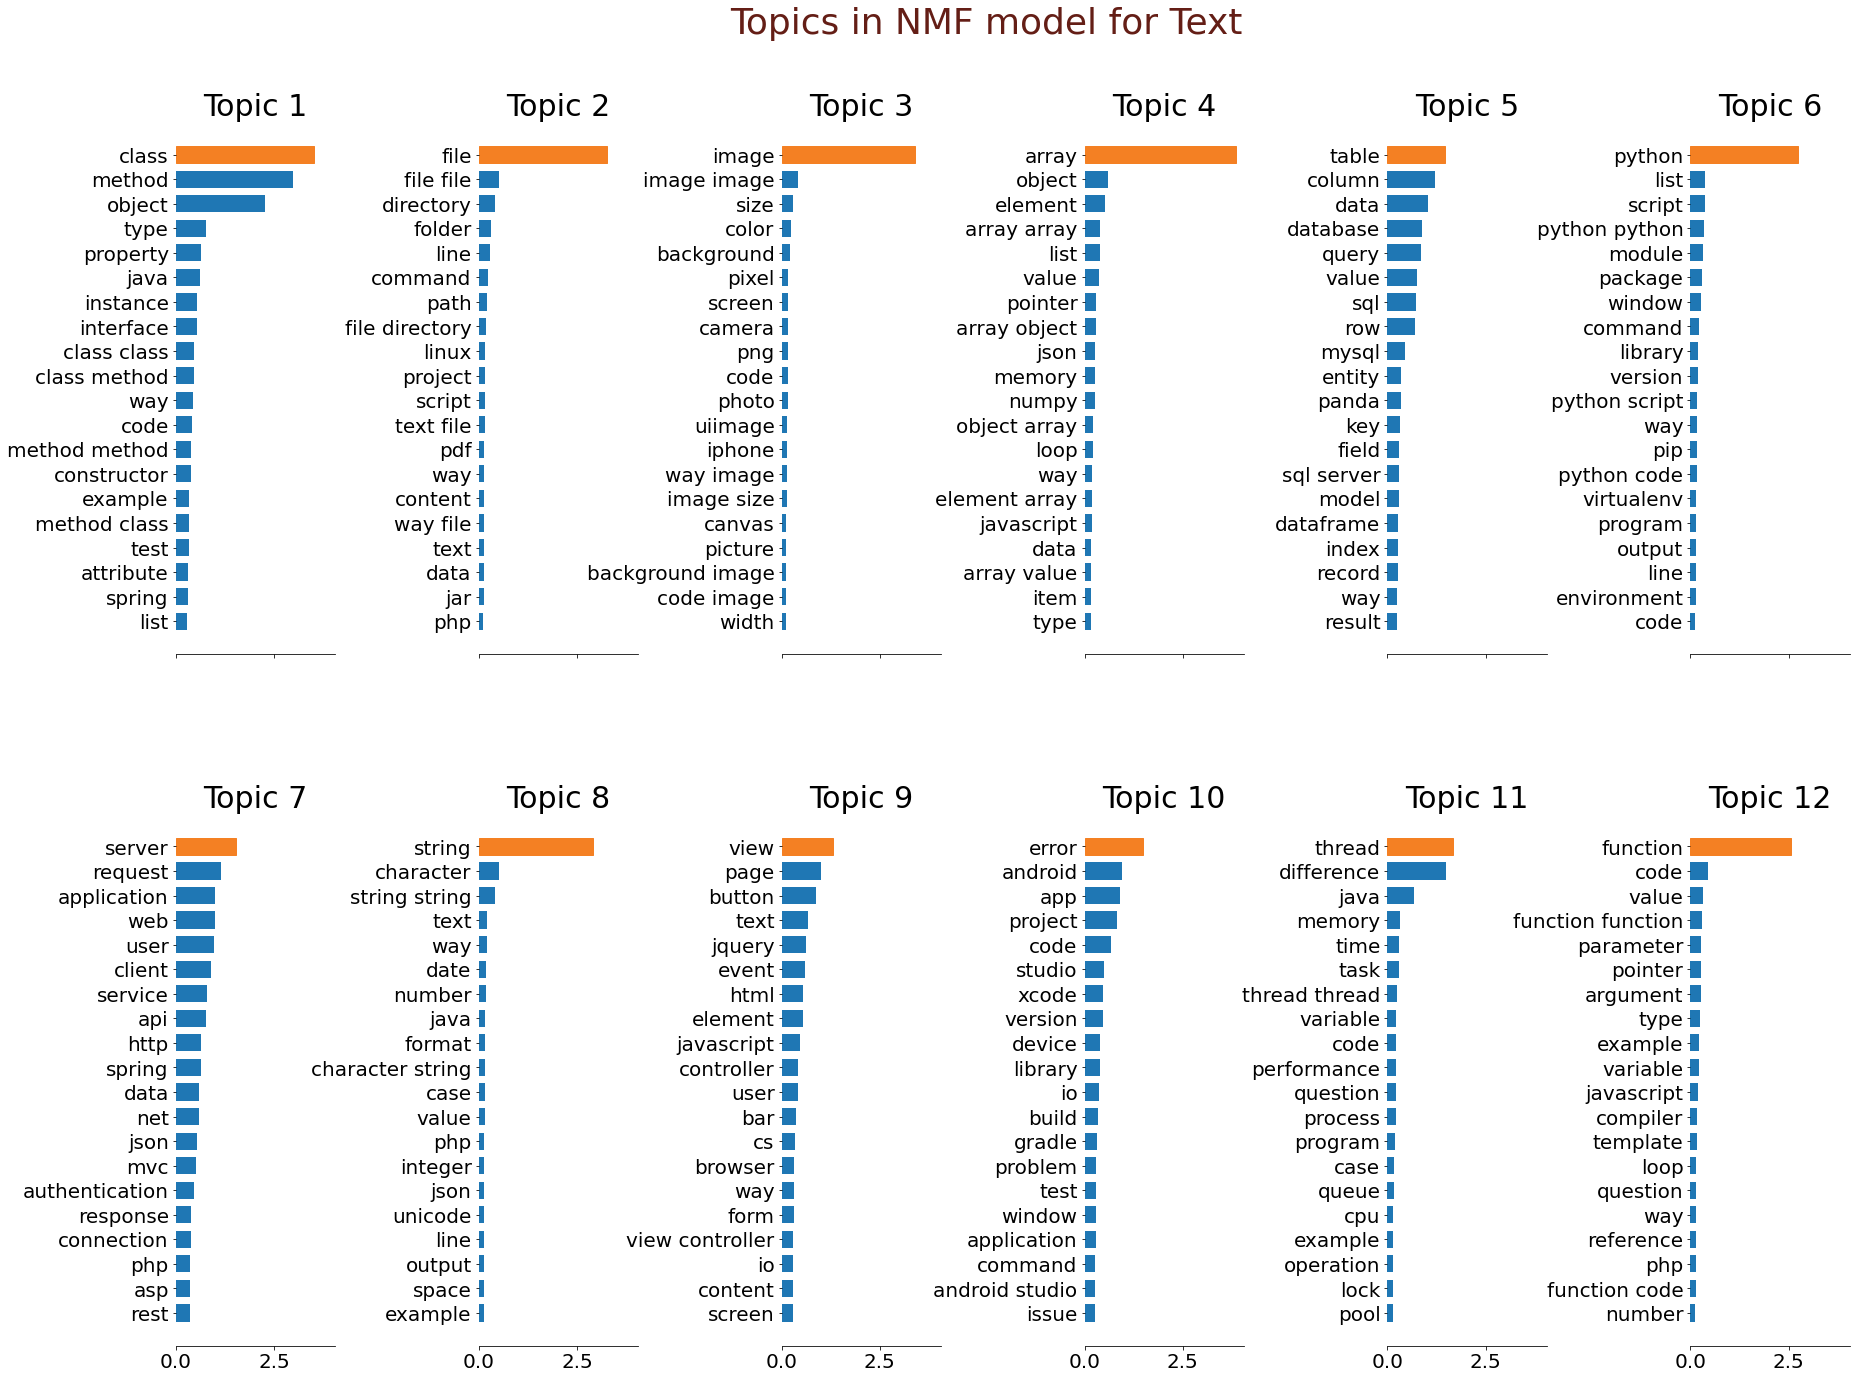

In [276]:
n_topics = 12


# Initializing the NMF
full_nmf = NMF(n_components=n_topics,
               init='nndsvd',
               random_state=10)

# Fit NMF on Body vectorized
full_nmf.fit(X_tf_idf)


# Plot the 12 first topics
ff_feature_names = vectorizer.get_feature_names()
plot_top_words(full_nmf, ff_feature_names, 20, 12,
               'Topics in NMF model for Text')

Predict topic distribution for unseen text with LDA

In [277]:
data = [['Is there any way to update data from a sql database from a api using android studio with java?', ['java' , 'sql']], ['Is WCF thread safe ?', ['C#', '.net']]]

In [278]:
test_text=pd.DataFrame(data,columns=['text','tags'])

In [279]:
test_text

,text,tags
0,Is there any way to update data from a sql dat...,"[java, sql]"
1,Is WCF thread safe ?,"[C#, .net]"


In [280]:
new_text_corpus =  id2word.doc2bow(test_text['text'][0].split())
result0=lda_model[new_text_corpus]

In [281]:
def sort_key(t):
    return t[1]


n=1

In [282]:
result0.sort(key=sort_key, reverse=True)

In [283]:
result0[:n]

[(4, 0.5475384)]

In [294]:
y_binarized_true0=multilabel_binarizer.transform(test_text['tags'][0])
y_binarized_predict0=multilabel_binarizer.transform(['jquery','javascript'])

In [295]:
jaccard_score(y_binarized_true0, y_binarized_predict0, average='macro')

0.0

In [298]:

doc_topic = pd.DataFrame(lda_model
                             .get_document_topics(corpus,
                                                  minimum_probability=0))
for topic in doc_topic.columns:
    doc_topic[topic] = doc_topic[topic].apply(lambda x : x[1])

print('document/tag : ', y_binarized.shape)
print('document/topic : ', doc_topic.shape)

document/tag :  (21293, 30)
document/topic :  (21293, 9)


In [299]:
topic_tag = np.matmul(doc_topic.T, y_binarized)
topic_tag.shape

(9, 30)

In [301]:
topic_tag.head(9)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,84.847466,483.482745,36.155706,50.014256,22.079212,184.901279,45.528109,203.663194,368.365903,390.382349,...,26.429813,39.407563,103.067726,21.324946,12.328825,19.615949,12.855931,214.821250,24.889882,143.636292
1,198.062048,200.406960,215.732409,138.947376,32.221584,414.731209,57.980415,19.670773,22.593350,129.188905,...,34.768983,210.344002,268.056313,75.180434,182.681624,39.822123,16.203505,47.553415,56.971741,59.586092
2,107.927550,54.162939,22.266726,18.607652,76.356021,209.993277,128.756970,25.285232,23.462383,48.013929,...,89.877640,76.842484,605.428763,20.680288,18.130437,158.996018,163.746857,37.212656,11.955247,16.427823
3,164.607564,89.078805,38.535996,30.617757,303.453040,334.813282,688.182378,27.004037,101.271319,222.826621,...,112.868041,146.047749,491.715652,25.360624,26.954171,35.492901,109.424793,49.771041,42.172922,34.819606
4,140.072704,173.728140,71.257477,97.110427,34.144883,313.279546,66.103348,46.586583,23.086239,66.126634,...,75.783681,117.667077,264.025221,90.356979,155.125230,276.395797,22.484090,44.313374,12.112531,27.864911
5,143.026735,390.329695,44.524604,32.803086,144.909717,219.296632,238.322536,21.160302,54.129131,75.245987,...,35.645460,161.888826,542.244499,51.106128,34.561906,27.196292,26.239095,37.184865,244.613911,92.675527
6,225.240146,92.865201,64.122638,63.033276,31.328547,332.927474,84.704876,25.989967,34.662704,56.487716,...,24.482591,31.639818,96.045292,26.340280,17.419251,11.429132,11.316456,20.323400,39.362177,65.625672
7,232.979041,124.030707,27.838452,18.145886,193.351675,414.125331,360.298821,44.926149,18.843834,46.022720,...,159.204176,49.358657,401.398071,17.861005,22.295322,48.799773,67.817945,35.996546,28.360326,22.110203
8,43.236746,218.914810,19.565992,25.720286,27.155321,87.931970,44.122547,72.713762,48.585139,122.705142,...,28.939616,59.803825,85.018463,116.789317,8.503236,13.252015,14.911328,127.823453,12.561263,155.253876


In [302]:
y_results = pd.DataFrame(y)
y_results["best_topic"] = doc_topic.idxmax(axis=1).values
y_results["nb_tags"] = y_results["Tags"].apply(lambda x : len(x))

df_y_bin = pd.DataFrame(y_binarized)
df_dict = dict(
    list(
        df_y_bin.groupby(df_y_bin.index)
    )
)

tags_num = []
for k, v in df_dict.items():
    check = v.columns[(v == 1).any()]
    tags_num.append(check.to_list())

y_results["y_true"] = tags_num
y_results.head(3)

,Tags,best_topic,nb_tags,y_true
0,[linux],5,1,[15]
1,"[php, mysql]",1,2,"[17, 21]"
2,"[ios, cocoa-touch]",0,2,"[7, 10]"


In [303]:
# Select predicted tags in Topics / Tags matrix
list_tag = []
for row in y_results.itertuples():
    nb_tags = row.nb_tags
    best_topic = row.best_topic
    row_tags = list(topic_tag.iloc[best_topic]\
                    .sort_values(ascending=False)[0:nb_tags].index)
    list_tag.append(row_tags)
    
y_results["y_pred"] = list_tag
y_results.head(3)

,Tags,best_topic,nb_tags,y_true,y_pred
0,[linux],5,1,[15],[22]
1,"[php, mysql]",1,2,"[17, 21]","[12, 5]"
2,"[ios, cocoa-touch]",0,2,"[7, 10]","[10, 13]"


In [304]:
def metrics_score(model, df, y_true, y_pred):

    if(df is not None):
        temp_df = df
    else:
        temp_df = pd.DataFrame(index=["Accuracy", "F1",
                                      "Jaccard", "Recall",
                                      "Precision"],
                               columns=[model])
        
    scores = []
    scores.append(metrics.accuracy_score(y_true, 
                                         y_pred))
    scores.append(metrics.f1_score(y_pred, 
                                   y_true, 
                                   average='weighted'))
    scores.append(metrics.jaccard_score(y_true, 
                                        y_pred, 
                                        average='weighted'))
    scores.append(metrics.recall_score(y_true, 
                                       y_pred, 
                                       average='weighted'))
    scores.append(metrics.precision_score(y_true, 
                                          y_pred, 
                                          average='weighted'))
    temp_df[model] = scores
    
    return temp_df

In [305]:

lda_y_pred = np.zeros(y_binarized.shape)
n = 0
for row in y_results.y_pred.values:
    for i in range(len(row)):
        lda_y_pred[n,row[i]] = 1
    n+=1
    
lda_y_true = np.zeros(y_binarized.shape)
m = 0
for row in y_results.y_true.values:
    for i in range(len(row)):
        lda_y_true[m,row[i]] = 1
    m+=1

In [306]:
df_metrics_compare = metrics_score("LDA", df=None,
                                   y_true=lda_y_true,
                                   y_pred=lda_y_pred)
df_metrics_compare

,LDA
Accuracy,0.136524
F1,0.315372
Jaccard,0.104608
Recall,0.245602
Precision,0.173875


In [296]:
new_text_corpus1 =  id2word.doc2bow(test_text['text'][1].split())
results1=lda_model[new_text_corpus1]
results1.sort(key=sort_key, reverse=True)
results1[:n]

[(1, 0.4267523)]

In [297]:
# Create train and test split (30%)
X_train, X_test, y_train, y_test = train_test_split(X_tf_idf, y_binarized,
                                                    test_size=0.3, random_state=10)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))


X_train shape : (14905, 3524)
X_test shape : (6388, 3524)
y_train shape : (14905, 30)
y_test shape : (6388, 30)


Baseline model : logistic regression sans réduction de dimensions

In [288]:
# Initialize Logistic Regression with OneVsRest
#penalty — Specify the norm of the penalty.
#C — Inverse of regularization strength; smaller values specify stronger regularization.
param_logit = {"estimator__C": [2,3,4,5,8,10, 0.1],
               "estimator__penalty": ["l1", "l2"],
               "estimator__solver": ["liblinear"]}

logit_cv = GridSearchCV(OneVsRestClassifier(LogisticRegression()),
                              param_grid=param_logit,
                              n_jobs=-1,
                              cv=5,
                              return_train_score = True
                              )
best=logit_cv.fit(X_train, y_train)

best.best_params_

best.best_score_

y_pred_logit=logit_cv.predict(X_test)

#to do add label 
print(classification_report(y_test,y_pred_logit))

jaccardscore=jaccard_score(y_test, y_pred_logit, average='weighted')
print("score jaccard de logit ", jaccardscore)

# Inverse transform
y_test_pred_logit_inversed = multilabel_binarizer.inverse_transform(y_pred_logit)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)

print(" Logistic reg model , 2 first tags : actual vs predicted")

print("Actual:", y_test_inversed[0:3])
print("Predicted:", y_test_pred_logit_inversed[0:3])


              precision    recall  f1-score   support

           0       0.63      0.28      0.39       392
           1       0.95      0.80      0.87       579
           2       0.65      0.32      0.43       159
           3       0.83      0.51      0.63       164
           4       0.51      0.29      0.37       250
           5       0.66      0.45      0.53       725
           6       0.75      0.48      0.59       527
           7       0.28      0.08      0.12       152
           8       0.79      0.55      0.65       230
           9       0.65      0.40      0.50       337
          10       0.78      0.64      0.70       697
          11       0.61      0.32      0.41       409
          12       0.85      0.64      0.73       869
          13       0.78      0.57      0.66       780
          14       0.79      0.63      0.70       288
          15       0.76      0.47      0.58       242
          16       0.72      0.49      0.58       143
          17       0.83    

logistic regression with dimension reduction using SVD 

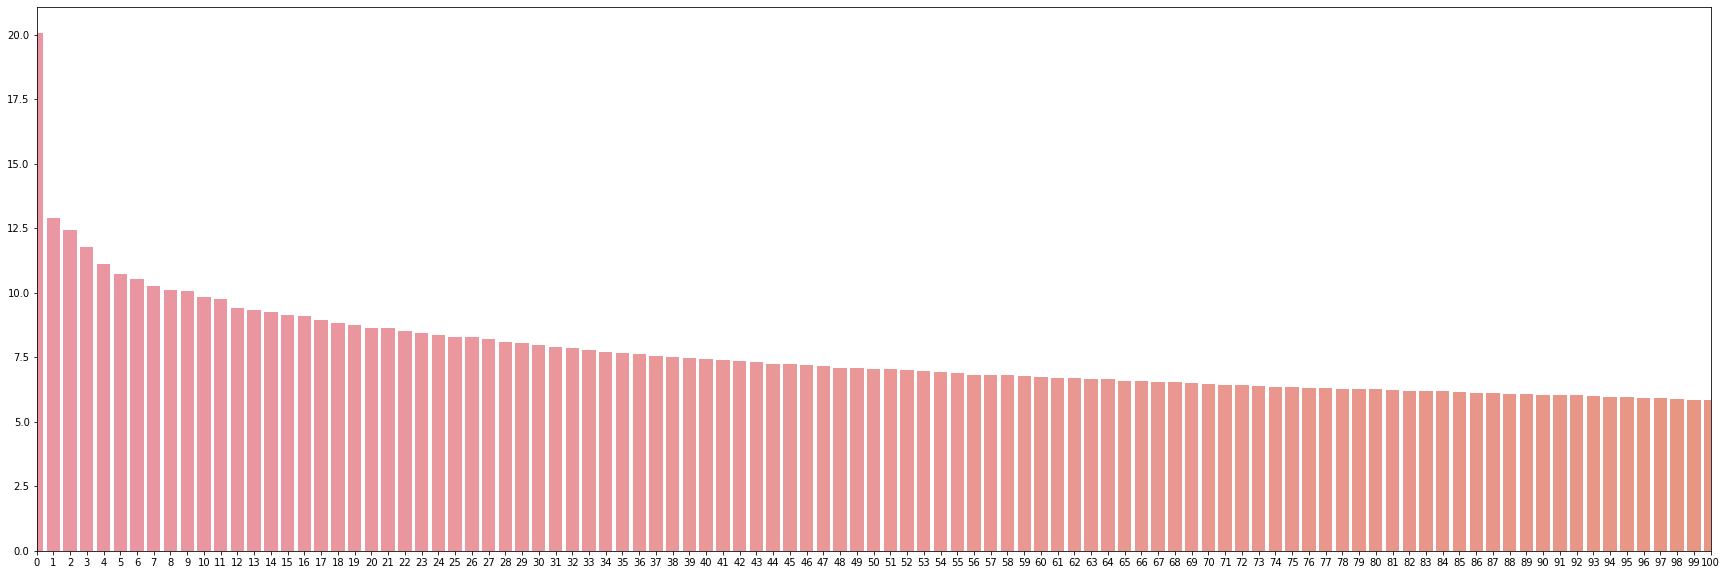

In [289]:
lsa_obj = TruncatedSVD(n_components=2000, n_iter=100, random_state=42)
tfidf_lsa_data = lsa_obj.fit_transform(X_tf_idf)
Sigma = lsa_obj.singular_values_
V_T = lsa_obj.components_.T
plt.figure(figsize=(30,10))
sh=sns.barplot(x=list(range(len(Sigma))), y = Sigma)
sh.set_xlim(0, 100)
plt.show()




In [290]:
var_explained = lsa_obj.explained_variance_ratio_.sum()
var_explained

0.9235863520870768

In [291]:

X_train_lsa, X_test_lsa, y_train, y_test = train_test_split(tfidf_lsa_data, y_binarized,
                                                    test_size=0.3, random_state=10)
print("X_train shape : {}".format(X_train_lsa.shape))
print("X_test shape : {}".format(X_test_lsa.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))
#Using our latent components in our modelling task for logistic regression
#Modèle Logistic regression ( OvR)
# Initialize Logistic Regression with OneVsRest
param_logit = {"estimator__C": [2,3,4,5,8,10, 0.1],
               "estimator__penalty": ["l1", "l2"],
               "estimator__solver": ["liblinear"]}

logit_lsa__cv = GridSearchCV(OneVsRestClassifier(LogisticRegression()),
                              param_grid=param_logit,
                              n_jobs=-1,
                              cv=5,
                              return_train_score = True
                              )
best=logit_lsa__cv.fit(X_train_lsa, y_train)

best.best_params_

best.best_score_

y_pred_logit=logit_lsa__cv.predict(X_test_lsa)

#to do add label 
print("logit_lsa classification_report ",classification_report(y_test,y_pred_logit))

score_jaccard_lsa=jaccard_score(y_test, y_pred_logit, average='weighted')
print(" score jaccard de logit avec lsa ", score_jaccard_lsa)

# Inverse transform
y_test_pred_logit_inversed_lsa = multilabel_binarizer.inverse_transform(y_pred_logit)
y_test_inversed_lsa = multilabel_binarizer.inverse_transform(y_test)

print(" Logistic reg model with lsa , 2 first tags : actual vs predicted")

print("Actual:", y_test_inversed_lsa[0:3])
print("Predicted:", y_test_pred_logit_inversed_lsa[0:3])

X_train shape : (14905, 2000)
X_test shape : (6388, 2000)
y_train shape : (14905, 30)
y_test shape : (6388, 30)
logit_lsa classification_report                precision    recall  f1-score   support

           0       0.60      0.26      0.36       392
           1       0.95      0.80      0.87       579
           2       0.65      0.30      0.41       159
           3       0.82      0.51      0.63       164
           4       0.49      0.26      0.34       250
           5       0.66      0.48      0.55       725
           6       0.74      0.49      0.59       527
           7       0.24      0.07      0.10       152
           8       0.81      0.56      0.66       230
           9       0.63      0.39      0.48       337
          10       0.75      0.62      0.68       697
          11       0.60      0.34      0.43       409
          12       0.85      0.65      0.74       869
          13       0.77      0.58      0.66       780
          14       0.80      0.60      0.68 

Random Forest classifier

In [292]:
param_rfc = {"estimator__max_depth": [10, 15,20],
             "estimator__max_features" : ['auto', 'sqrt'],
             "estimator__class_weight": ["balanced"]}

rfc_cv = GridSearchCV(OneVsRestClassifier(RandomForestClassifier()),
                            param_grid=param_rfc,
                            cv=2,
                            scoring="f1_weighted",
                            return_train_score = True,
                            verbose=3)

rfc_cv.fit(X_train, y_train)

print("Best params for RandomForestClassifier")

rfc_best_params = rfc_cv.best_params_
print(rfc_best_params)

rfc_best_params

rfc_best = {}
for i, j in rfc_best_params.items():
    rfc_best[i.replace("estimator__","")] =j

# Predict
y_test_pred_labels_tfidf_rfc = rfc_cv.predict(X_test)

# Inverse transform
y_test_pred_inversed_rfc = multilabel_binarizer.inverse_transform(y_test_pred_labels_tfidf_rfc)


print("Random Forest : Print  predicted Tags vs actual Tags")
print("True:", y_test_inversed[0:4])
print("Predicted:", y_test_pred_inversed_rfc[0:4])


jaccard_score(y_test, y_test_pred_labels_tfidf_rfc , average='weighted')

print(classification_report(y_test,y_test_pred_labels_tfidf_rfc))


Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END estimator__class_weight=balanced, estimator__max_depth=10, estimator__max_features=auto;, score=(train=0.758, test=0.613) total time=  11.5s
[CV 2/2] END estimator__class_weight=balanced, estimator__max_depth=10, estimator__max_features=auto;, score=(train=0.749, test=0.609) total time=  11.3s
[CV 1/2] END estimator__class_weight=balanced, estimator__max_depth=10, estimator__max_features=sqrt;, score=(train=0.761, test=0.613) total time=  11.1s
[CV 2/2] END estimator__class_weight=balanced, estimator__max_depth=10, estimator__max_features=sqrt;, score=(train=0.756, test=0.616) total time=  11.0s
[CV 1/2] END estimator__class_weight=balanced, estimator__max_depth=15, estimator__max_features=auto;, score=(train=0.832, test=0.618) total time=  14.8s
[CV 2/2] END estimator__class_weight=balanced, estimator__max_depth=15, estimator__max_features=auto;, score=(train=0.823, test=0.617) total time=  14.9s
[CV 1/2] END est

Export fitted model and Preprocessor

In [293]:
joblib.dump(logit_cv,'logisticreg_nlp_model.pkl')
joblib.dump(vectorizer,'tfidf_vectorizer.pkl')
joblib.dump(multilabel_binarizer,'multilabel_binarizer.pkl')


['multilabel_binarizer.pkl']